In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39835")
client

<Client: 'tcp://127.0.0.1:39835' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from xhistogram.xarray import histogram as xhist
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
chaos = '/tank/chaocean/tuchida/'
# savedir = '/tank/chaocean/tuchida/ECycle/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

xchunk = 100
ychunk = 100
zchunk = 4

nmembs = np.arange(100,148)

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 51  # 
yystart = 0
ntimes[yystart,dd:]

array([1529280, 1531440, 1533600, 1535760, 1537920, 1540080, 1542240,
       1544400, 1546560, 1548720, 1550880, 1553040, 1555200, 1557360,
       1559520, 1561680, 1563840, 1566000, 1568160, 1570320, 1572480,
       1574640])

In [6]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).chunk({'YC':ychunk,'YG':ychunk,
                              'XC':xchunk,'XG':xchunk})
grid = Grid(dsg, periodic=['X'])
Vol = (dsg.hFacC * dsg.rA * dsg.drF).where(dsg.maskC!=0.)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic, boundary=None):
  * center   time

In [9]:
for itime in ntimes[yystart,dd+1:]:
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds0 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['snap_diagOcn'], delta_t=2e2,
                                  iters=itime, 
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagUm'], delta_t=2e2,
                                  iters=itime, ignore_unknown_vars=True
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
            ds2 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                          % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagVm'], delta_t=2e2,
                                  iters=itime, ignore_unknown_vars=True
                                 ).isel(time=0
                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
            Um_dEdx = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%3d/run1967/ocn/diagUm' 
                                                          % nmemb), 
                                                  itrs=itime, rec=3,    # Vertical diss.
                                     # usememmap=True
                                                 ),
                                   dims=ds0.UVEL.dims, coords=ds0.UVEL.coords
                                  ).isel(Z=0).chunk({'YC':ychunk,'XG':xchunk})  
            Vm_dEdy = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%3d/run1967/ocn/diagVm' 
                                                          % nmemb), 
                                                  itrs=itime, rec=3,    # Vertical diss.
                                     # usememmap=True
                                                 ),
                                   dims=ds0.VVEL.dims, coords=ds0.VVEL.coords
                                  ).isel(Z=0).chunk({'YG':ychunk,'XC':xchunk}) 
        else:
            ds0 = xr.concat([ds0, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['snap_diagOcn'], delta_t=2e2,
                                                  iters=itime, 
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')   
            ds1 = xr.concat([ds1, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['diagUm'], delta_t=2e2,
                                                  iters=itime, ignore_unknown_vars=True
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')
            ds2 = xr.concat([ds2, open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                                          % (nmemb)), 
                                                  grid_dir=gdir,
                                                  prefix=['diagVm'], delta_t=2e2,
                                                  iters=itime, ignore_unknown_vars=True
                                                 ).isel(time=0
                                                       ).chunk({'YC':ychunk,'YG':ychunk,
                                                                'XC':xchunk,'XG':xchunk})
                           ], dim='nmemb')
            Um_dEdx = xr.concat([Um_dEdx,
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                    'memb%3d/run1967/ocn/diagUm' % nmemb), 
                                                  itrs=itime, rec=3,    # Vertical diss.
                                     # usememmap=True
                                                 ),
                                              dims=ds0.UVEL.isel(nmemb=0).dims, 
                                              coords=ds0.UVEL.isel(nmemb=0).coords
                                             ).isel(Z=0).chunk({'YC':ychunk,'XG':xchunk})
                                ], dim='nmemb') 
            Vm_dEdy = xr.concat([Vm_dEdy,
                                 xr.DataArray(mitutils.rdmds(op.join(ddir,
                                                    'memb%3d/run1967/ocn/diagVm' % nmemb), 
                                                  itrs=itime, rec=3,    # Vertical diss.
                                     # usememmap=True
                                                 ),
                                              dims=ds0.VVEL.isel(nmemb=0).dims, 
                                              coords=ds0.VVEL.isel(nmemb=0).coords
                                             ).isel(Z=0).chunk({'YG':ychunk,'XC':xchunk})
                                ], dim='nmemb')  

    ds0.coords['nmemb'] = ('nmemb',nmembs)
    ds1.coords['nmemb'] = ('nmemb',nmembs)
    ds2.coords['nmemb'] = ('nmemb',nmembs)
    Um_dEdx.coords['nmemb'] = ('nmemb',nmembs)
    Vm_dEdy.coords['nmemb'] = ('nmemb',nmembs)
    
    ds0m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['snap_diagOcn'], delta_t=2e2,
                           iters=itime, 
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    ds1m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['diagUm'], delta_t=2e2,
                           iters=itime, ignore_unknown_vars=True
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    ds2m = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn/'), 
                           grid_dir=gdir,
                           prefix=['diagVm'], delta_t=2e2,
                           iters=itime, ignore_unknown_vars=True
                          ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                                'XC':xchunk,'XG':xchunk})
    Um_dEdxm = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagUm'), 
                                           itrs=itime, rec=3,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.UVEL.dims, coords=ds0m.UVEL.coords
                           ).isel(Z=0).chunk({'YC':ychunk,'XG':xchunk}) 
    Vm_dEdym = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagVm'), 
                                           itrs=itime, rec=3,    # Vertical dissipation
                                     # usememmap=True
                                          ),
                            dims=ds0m.VVEL.dims, coords=ds0m.VVEL.coords
                           ).isel(Z=0).chunk({'YG':ychunk,'XC':xchunk})
    
    up = ds0.UVEL - ds0m.UVEL
    vp = ds0.VVEL - ds0m.VVEL
    Pxp = ((ds1.Um_dPHdx - ds1m.Um_dPHdx)
           + (Um_dEdx - Um_dEdxm)
          )
    Pyp = ((ds2.Vm_dPHdy - ds2m.Vm_dPHdy)
           + (Vm_dEdy - Vm_dEdym)
          )
    
    pwrk = ((grid.interp((up * Pxp).mean('nmemb',skipna=True),'X') 
             + grid.interp((vp * Pyp).mean('nmemb',skipna=True),
                           'Y',boundary='extend')
            ).where(dsg.maskC!=0.).reset_coords(drop=True)
           ).compute().chunk({'YC':ychunk,'XC':xchunk})
    del Um_dEdx, Vm_dEdy, Um_dEdxm, Vm_dEdym
    del Pxp, Pyp
    ab = ((grid.interp((up * (ds1.AB_gU-ds1m.AB_gU)).mean('nmemb',skipna=True),'X') 
           + grid.interp((vp * (ds2.AB_gV-ds2m.AB_gV)).mean('nmemb',skipna=True),
                         'Y',boundary='extend')
          ).where(dsg.maskC!=0.).reset_coords(drop=True)
         ).compute().chunk({'YC':ychunk,'XC':xchunk})
    
    dsave = pwrk.to_dataset(name='PRES')
    dsave['ADAM'] = ab
    dsave.to_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                          % (years[yystart],itime)), mode='w')
    dsave.close()
        
    ds0.close()
    ds1.close()
    ds2.close()
    ds0m.close()
    ds1m.close()
    ds2m.close()

    print(itime)

1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [11]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
for itime in ntimes[yystart]:
    if itime == ntimes[yystart,0]:
        P = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                                  % (years[yystart],itime))
                         ).PRES
    else:
        P = xr.concat([P, xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                                  % (years[yystart],itime))
                                        ).PRES
                       ], 'time')
    # print(itime)
        
((P*Vol).sel(
           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
           # XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
 / Vol.sel(
           # Z=slice(None,-1e3),YC=slice(ymin,ymax),
           # XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
).reset_coords(drop=True).chunk({'time':-1}
                               ).to_dataset(name='PRES').to_zarr(op.join(savedir,
                  #                   '%4d/Eddy/PRES_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                  # % (years[yystart],ymin,ymax,xmin,xmax)
                                    '%4d/Eddy/PRES_VolAve.zarr' 
                  % (years[yystart])
                                                                      ), mode='w')

In [12]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
for itime in ntimes[yystart]:
    if itime == ntimes[yystart,0]:
        AB = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                                  % (years[yystart],itime))
                         ).ADAM
    else:
        AB = xr.concat([AB, xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                                  % (years[yystart],itime))
                                        ).ADAM
                       ], 'time')
    # print(itime)
        
((AB*Vol).sel(
           Z=slice(None,-1e3),YC=slice(ymin,ymax),
           XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
 / Vol.sel(
           Z=slice(None,-1e3),YC=slice(ymin,ymax),
           XC=slice(xmin,xmax)
          ).sum(['Z','YC','XC'],skipna=True)
).reset_coords(drop=True).chunk({'time':-1}
                               ).to_dataset(name='ADAM').to_zarr(op.join(savedir,
                                    '%4d/Eddy/A-B_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                  % (years[yystart],ymin,ymax,xmin,xmax)
                  #                   '%4d/Eddy/A-B_VolAve.zarr' 
                  # % (years[yystart])
                                                                      ), mode='w')

In [7]:
dse = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKE_bud.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsk = xr.open_zarr(op.join(savedir,'%4d/%010d/K-k.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dst = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/EKETEND.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsa = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Advect.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsh = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Div_vh.zarr' 
                           % (years[yystart],ntimes[0,0]))
                  )
dsf = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Forcing.zarr' 
                          % (years[yystart],ntimes[0,0]))
                  )
dsv = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Disv.zarr' 
                          % (years[yystart],ntimes[0,0]))
                  )
dsd = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/Diss.zarr' 
                          % (years[yystart],ntimes[0,0]))
                  )
dsH = xr.open_zarr(op.join(savedir,'%4d/%010d/GradH.zarr' 
                           % (years[0],ntimes[0,0]))
                  )
dsb = xr.open_zarr(op.join(savedir,'%4d/%010d/Eddy/wb.zarr' 
                          % (years[yystart],ntimes[0,0]))
                  )
dss = xr.open_zarr(op.join(savedir,'%4d/%010d/S-P.zarr' 
                          % (years[yystart],ntimes[0,0]))
                  )
dse

<xarray.Dataset>
Dimensions:  (Z: 46, YC: 900, XC: 1000)
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
Data variables:
    ADAM     (Z, YC, XC) float32 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    PRES     (Z, YC, XC) float64 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>

In [8]:
rhs0 = ((dse.PRES 
         # - dsb.wb    # (= - dsh.Gh - dsH.H_)
         # + dsh.Gh
        ) 
        + (grid.interp(dsa.Um_Advec,"X") 
           + grid.interp(dsa.Vm_Advec,"Y",boundary='extend'))
        # + dsH.H_
        + (grid.interp(dsd.Um_diss+dsv.Um_disv,'X') 
           + grid.interp(dsd.Vm_diss+dsv.Vm_disv,'Y',boundary='extend')
          ) + dse.ADAM
       )
rhs1 = ((dse.PRES 
         - dsb.wb    # (= - dsh.Gh - dsH.H_)
         + dsh.Gh
        ) 
        + (grid.interp(dsa.Um_Advec,"X") 
           + grid.interp(dsa.Vm_Advec,"Y",boundary='extend'))
        + dsH.H_
        + (grid.interp(dsd.Um_diss+dsv.Um_disv,'X') 
           + grid.interp(dsd.Vm_diss+dsv.Vm_disv,'Y',boundary='extend')
          ) + dse.ADAM
       )
rhs0[dict(Z=0)] += (grid.interp(dsf.Um_forc,"X") 
                   + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                  )
rhs1[dict(Z=0)] += (grid.interp(dsf.Um_forc,"X") 
                   + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                  )
rhs1

<xarray.DataArray (Z: 46, YC: 900, XC: 1000)>
dask.array<setitem, shape=(46, 900, 1000), dtype=float64, chunksize=(4, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    Depth    (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    drF      (Z) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    ...       ...
    iter     int64 ...
    maskC    (Z, YC, XC) bool dask.array<chunksize=(4, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    time     timedelta64[ns] ...

In [13]:
tend = dst.TEND/86400
tend.name = 'tend'
rhs0.name = 'RHS0'
rhs1.name = 'RHS1'

# histo0 = xhist(rhs0, 
#               tend,
#               bins=[np.concatenate((-np.logspace(-6,-9,15),
#                                     np.concatenate((np.linspace(-9e-10,9e-10,11),
#                                                     np.logspace(-9,-6,15))))), 
#                     np.concatenate((-np.logspace(-6,-9,15),
#                                     np.concatenate((np.linspace(-9e-10,9e-10,11),
#                                                     np.logspace(-9,-6,15)))))
#                    ]
#      ).compute()
histo1 = xhist(rhs1, 
              tend,
              bins=[np.concatenate((-np.logspace(-7,-10,15),
                                    np.concatenate((np.linspace(-9e-11,9e-11,11),
                                                    np.logspace(-10,-7,15))))), 
                    np.concatenate((-np.logspace(-7,-10,15),
                                    np.concatenate((np.linspace(-9e-11,9e-11,11),
                                                    np.logspace(-10,-7,15)))))
                   ]
     ).compute()

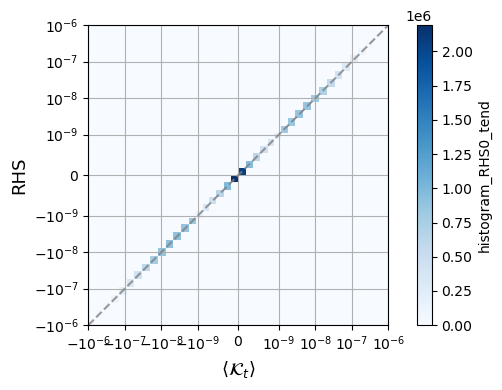

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

histo0.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(-1e-6,1e-6), np.linspace(-1e-6,1e-6), c='grey', ls='--', alpha=.8)
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-9)
ax.set_yscale('symlog', linthresh=1e-9)
ax.set_ylim([-1e-6,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\langle\mathcal{K}_t\rangle$", 
              fontsize=13)
ax.set_ylabel(r"RHS", fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

# plt.savefig(op.join(savedir,'Figures/Histo_EKEt_recon_%010d.pdf' % ntimes[0,0]))

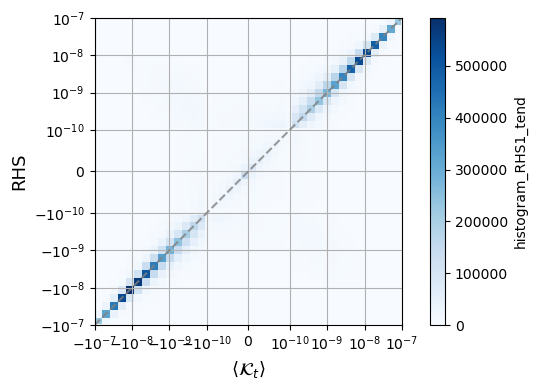

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

histo1.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(-1e-7,1e-7), np.linspace(-1e-7,1e-7), c='grey', ls='--', alpha=.8)
# ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('symlog', linthresh=1e-10)
ax.set_ylim([-1e-7,1e-7])
ax.set_xlim([-1e-7,1e-7])
ax.set_xlabel(r"$\langle\mathcal{K}_t\rangle$", 
              fontsize=13)
ax.set_ylabel(r"RHS", fontsize=13)

ax.grid(True)
ax.set_aspect('equal')

plt.savefig(op.join(savedir,'Figures/Histo_EKEt_recon_%010d.pdf' % ntimes[0,0]))

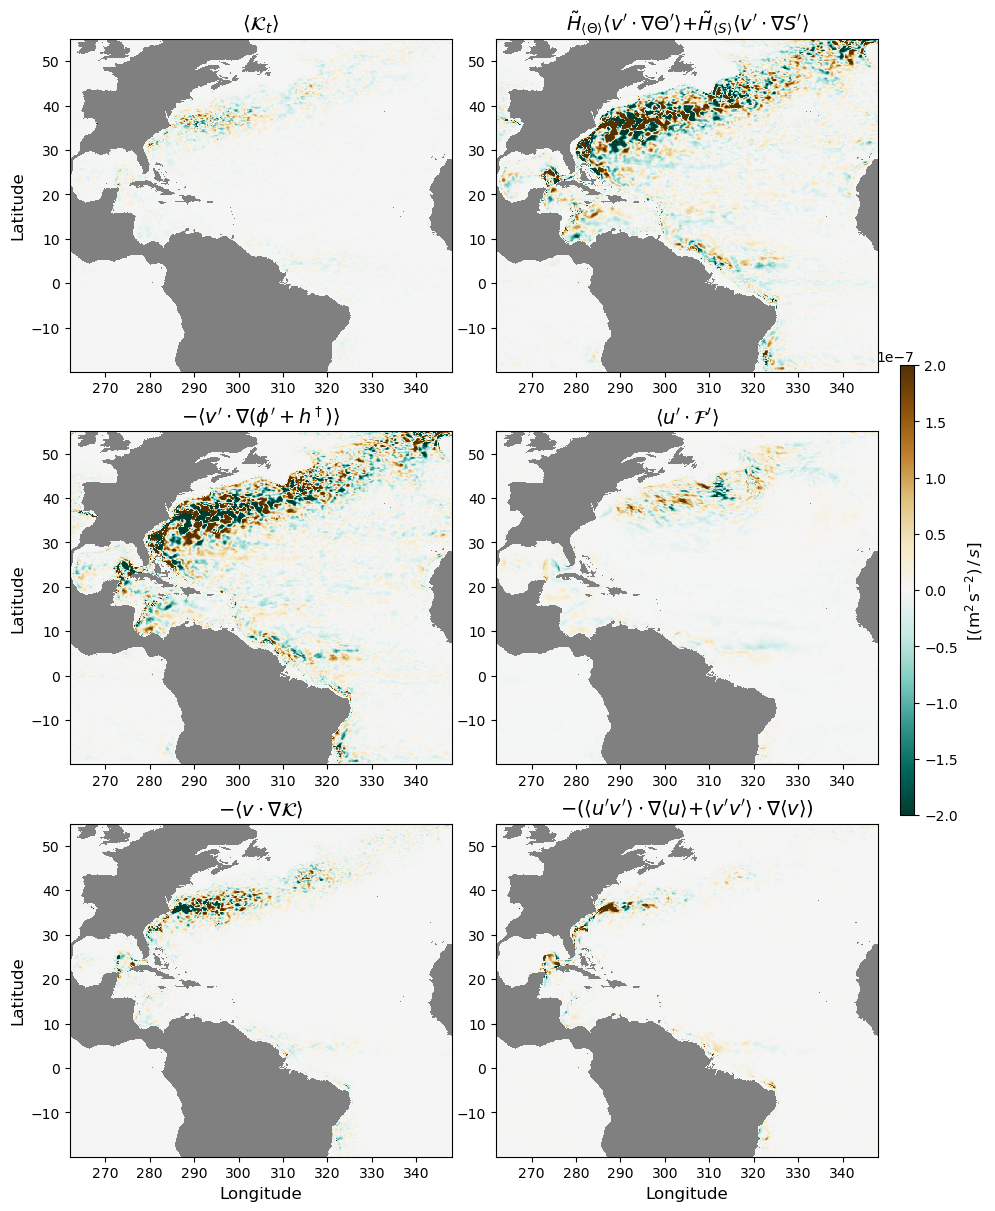

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,15))

im = axes[0,0].pcolormesh(dse.XC, dse.YC, 
                          ((dst.TEND * dsg.drF * dsg.hFacC
                           ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)
                           / 86400/1e3),
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
# axes[0,1].pcolormesh(dse.XC, dse.YC, 
#                      (rhs * dsg.drF * dsg.hFacC
#                      ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
#                      cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
#                      rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC, 
                     (dsH.H_ * dsg.drF * dsg.hFacC
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[1,0].pcolormesh(dse.XC, dse.YC, 
                     ((dse.PRES - dsb.wb + dsh.Gh
                      ) * dsg.drF * dsg.hFacC
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsf.Um_forc,"X") 
                      + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                     ),
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[2,0].pcolormesh(dse.XC, dse.YC, 
                     ((grid.interp(dsa.Um_Advec,"X") 
                       + grid.interp(dsa.Vm_Advec,"Y",boundary='extend')
                       # - dsk.Kk
                       + dss.ShProd
                      ) * dsg.drF * dsg.hFacC
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
axes[2,1].pcolormesh(dse.XC, dse.YC, 
                     (-dss.ShProd * dsg.drF * dsg.hFacC
                     ).sel(Z=slice(None,-1e3)).sum('Z',skipna=True)/1e3,
                     cmap='BrBG_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[0,0].set_title(r"$\langle\mathcal{K}_t\rangle$", fontsize=14)
# axes[0,1].set_title(r"RHS", fontsize=14)
axes[0,1].set_title(r"$\tilde{H}_{\langle\Theta\rangle}\langle v'\cdot\nabla\Theta'\rangle$" +
                    r"$+ \tilde{H}_{\langle S\rangle}\langle v'\cdot\nabla S'\rangle$", fontsize=14)
axes[1,0].set_title(r"$-\langle v'\cdot\nabla(\phi'+h^\dagger)\rangle$", fontsize=14)
axes[1,1].set_title(r"$\langle u'\cdot\mathcal{F}'\rangle$", 
                    fontsize=14)
axes[2,0].set_title(r"$-\langle v\cdot\nabla\mathcal{K}\rangle$", fontsize=14)
axes[2,1].set_title(r"$-(\langle u'v'\rangle\cdot\nabla\langle u\rangle$" + 
                    r"$+ \langle v'v'\rangle\cdot\nabla\langle v\rangle)$", fontsize=14)

axes[0,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_xlabel('Longitude', fontsize=12)
axes[2,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/EKE_aveZ1000budget_%010d.pdf' % ntimes[0,0]))

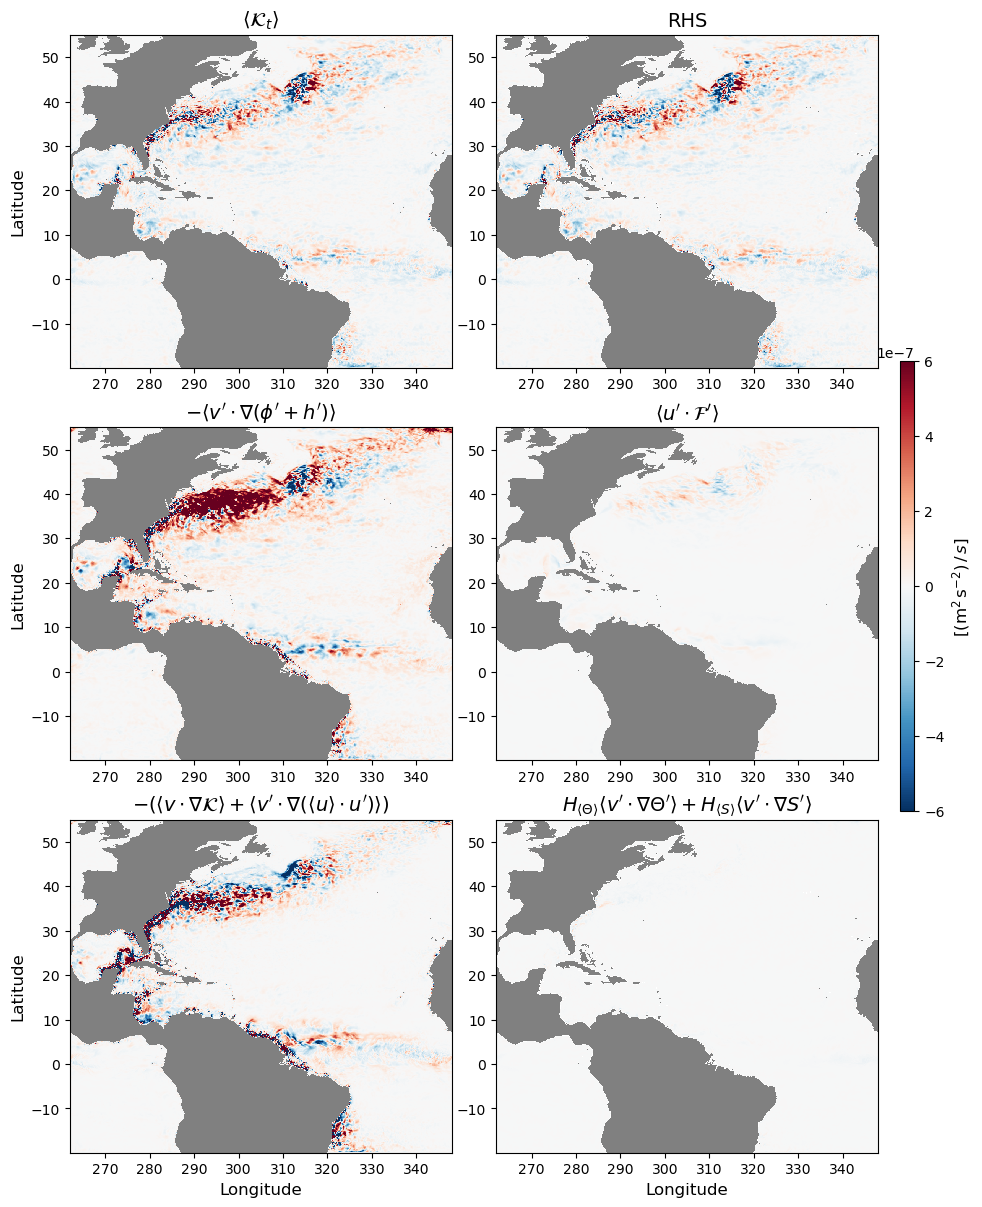

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,15))

im = axes[0,0].pcolormesh(dse.XC, dse.YC, 
                          (dst.TEND.isel(Z=0) / 86400),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC, 
                     rhs.isel(Z=0),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[1,0].pcolormesh(dse.XC, dse.YC, 
                     (dse.PRES - dsb.wb + dsh.Gh).isel(Z=0),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsf.Um_forc,"X") 
                      + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                     ),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[2,0].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsa.Um_Advec,"X") 
                      + grid.interp(dsa.Vm_Advec,"Y",boundary='extend')
                      - dsk.Kk).isel(Z=0),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[2,1].pcolormesh(dse.XC, dse.YC, 
                     dsH.H_.isel(Z=0),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[0,0].set_title(r"$\langle\mathcal{K}_t\rangle$", fontsize=14)
axes[0,1].set_title(r"RHS", fontsize=14)
axes[1,0].set_title(r"$-\langle v'\cdot\nabla(\phi'+h')\rangle$", fontsize=14)
axes[1,1].set_title(r"$\langle u'\cdot\mathcal{F}'\rangle$", 
                    fontsize=14)
axes[2,0].set_title(r"$-(\langle v\cdot\nabla\mathcal{K}\rangle + \langle v'\cdot\nabla(\langle u\rangle\cdot u')\rangle)$", fontsize=14)
axes[2,1].set_title(r"$H_{\langle\Theta\rangle}\langle v'\cdot\nabla\Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot\nabla S'\rangle$", fontsize=14)

axes[0,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_xlabel('Longitude', fontsize=12)
axes[2,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/EKE_budget_%010d.pdf' % ntimes[0,0]))

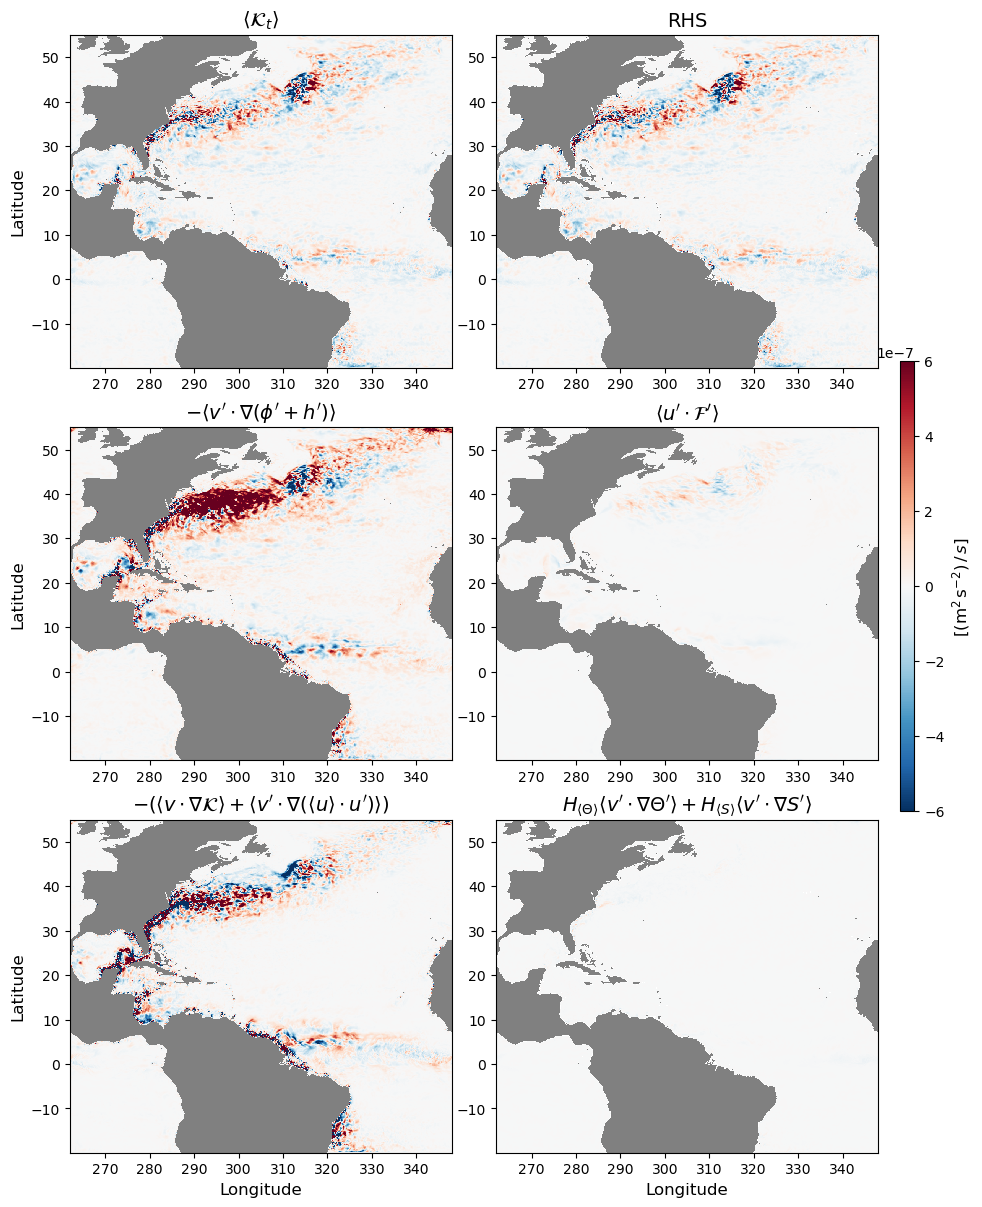

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,15))

im = axes[0,0].pcolormesh(dse.XC, dse.YC, 
                          (dst.TEND.sel(Z=500,method='nearest') / 86400),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC, 
                     rhs.sel(Z=500,method='nearest'),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[1,0].pcolormesh(dse.XC, dse.YC, 
                     (dse.PRES - dsb.wb + dsh.Gh).sel(Z=500,method='nearest'),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsf.Um_forc,"X") 
                      + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                     ),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[2,0].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsa.Um_Advec,"X") 
                      + grid.interp(dsa.Vm_Advec,"Y",boundary='extend')
                      - dsk.Kk).sel(Z=500,method='nearest'),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)
axes[2,1].pcolormesh(dse.XC, dse.YC, 
                     dsH.H_.sel(Z=500,method='nearest'),
                     cmap='RdBu_r', vmax=6e-7, vmin=-6e-7,
                     rasterized=True)

axes[0,0].set_title(r"$\langle\mathcal{K}_t\rangle$", fontsize=14)
axes[0,1].set_title(r"RHS", fontsize=14)
axes[1,0].set_title(r"$-\langle v'\cdot\nabla(\phi'+h')\rangle$", fontsize=14)
axes[1,1].set_title(r"$\langle u'\cdot\mathcal{F}'\rangle$", 
                    fontsize=14)
axes[2,0].set_title(r"$-(\langle v\cdot\nabla\mathcal{K}\rangle + \langle v'\cdot\nabla(\langle u\rangle\cdot u')\rangle)$", fontsize=14)
axes[2,1].set_title(r"$H_{\langle\Theta\rangle}\langle v'\cdot\nabla\Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot\nabla S'\rangle$", fontsize=14)

axes[0,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_xlabel('Longitude', fontsize=12)
axes[2,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/EKE_Z500budget_%010d.pdf' % ntimes[0,0]))

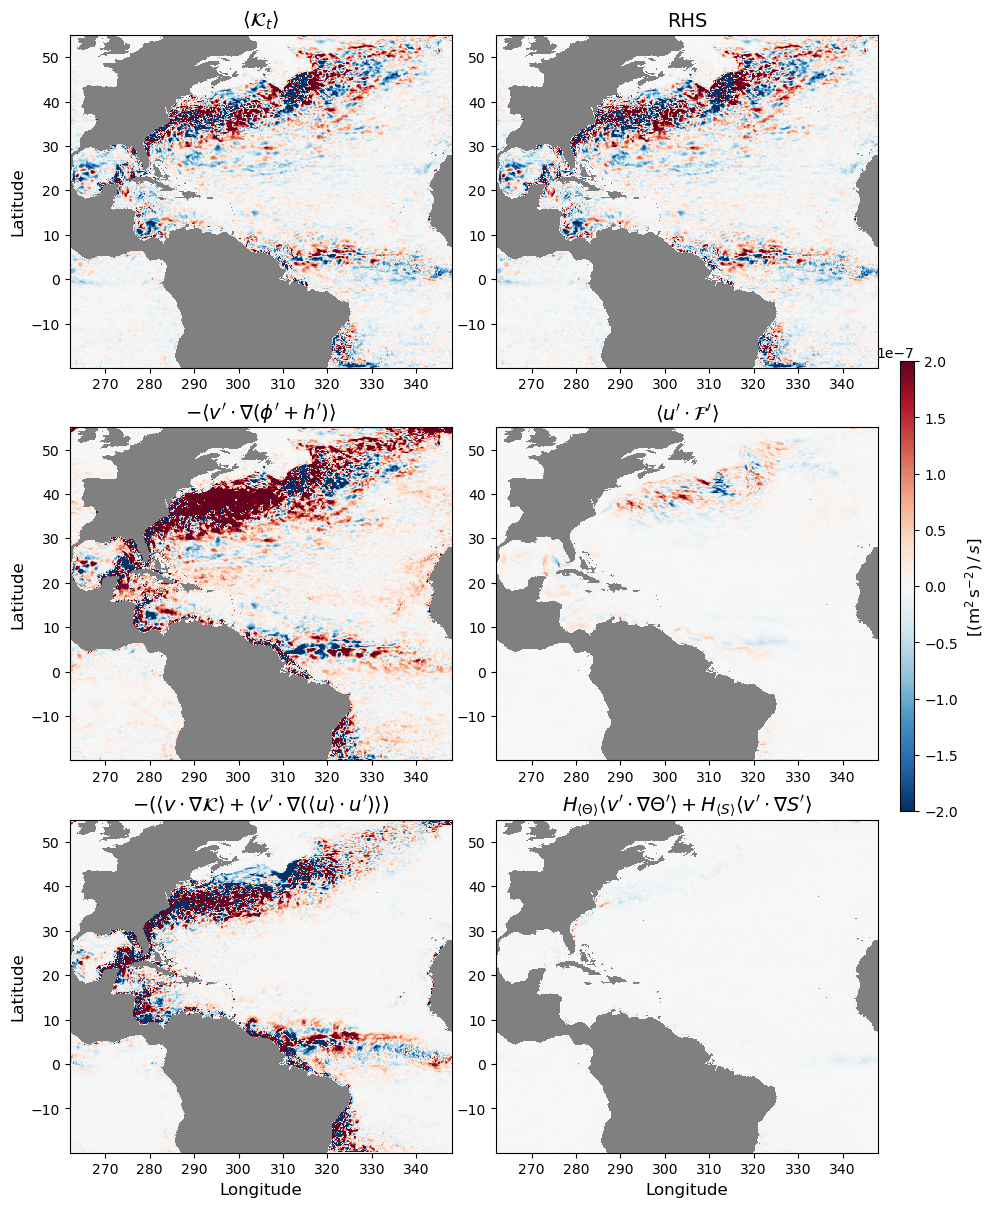

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,15))

im = axes[0,0].pcolormesh(dse.XC, dse.YC, 
                          (dst.TEND.sel(Z=1000,method='nearest') / 86400),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
axes[0,1].pcolormesh(dse.XC, dse.YC, 
                     rhs.sel(Z=1000,method='nearest'),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[1,0].pcolormesh(dse.XC, dse.YC, 
                     (dse.PRES - dsb.wb + dsh.Gh).sel(Z=1000,method='nearest'),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
axes[1,1].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsf.Um_forc,"X") 
                      + grid.interp(dsf.Vm_forc,"Y",boundary='extend')
                     ),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[2,0].pcolormesh(dse.XC, dse.YC, 
                     (grid.interp(dsa.Um_Advec,"X") 
                      + grid.interp(dsa.Vm_Advec,"Y",boundary='extend')
                      - dsk.Kk).sel(Z=1000,method='nearest'),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)
axes[2,1].pcolormesh(dse.XC, dse.YC, 
                     dsH.H_.sel(Z=1000,method='nearest'),
                     cmap='RdBu_r', vmax=2e-7, vmin=-2e-7,
                     rasterized=True)

axes[0,0].set_title(r"$\langle\mathcal{K}_t\rangle$", fontsize=14)
axes[0,1].set_title(r"RHS", fontsize=14)
axes[1,0].set_title(r"$-\langle v'\cdot\nabla(\phi'+h')\rangle$", fontsize=14)
axes[1,1].set_title(r"$\langle u'\cdot\mathcal{F}'\rangle$", 
                    fontsize=14)
axes[2,0].set_title(r"$-(\langle v\cdot\nabla\mathcal{K}\rangle + \langle v'\cdot\nabla(\langle u\rangle\cdot u')\rangle)$", fontsize=14)
axes[2,1].set_title(r"$H_{\langle\Theta\rangle}\langle v'\cdot\nabla\Theta'\rangle + H_{\langle S\rangle}\langle v'\cdot\nabla S'\rangle$", fontsize=14)

axes[0,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[0,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[1,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,0].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)
axes[2,1].pcolormesh(dsg.XC, dsg.YC, dsg.maskC.where(dsg.maskC!=1.).isel(Z=0),
                     vmin=-2, vmax=2., cmap='binary_r', rasterized=True)

fig.subplots_adjust(right=.86, wspace=.115, hspace=.06) 
cbax = fig.add_axes([0.88, 0.35, 0.013, 0.3])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[(m$^{2}\,$s$^{-2})\, /\, s$]", fontsize=12)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_ylabel('Latitude', fontsize=12)
axes[1,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_ylabel('Latitude', fontsize=12)
axes[2,0].set_xlabel('Longitude', fontsize=12)
axes[2,1].set_xlabel('Longitude', fontsize=12)

plt.savefig(op.join(savedir,'Figures/EKE_Z1000budget_%010d.pdf' % ntimes[0,0]))

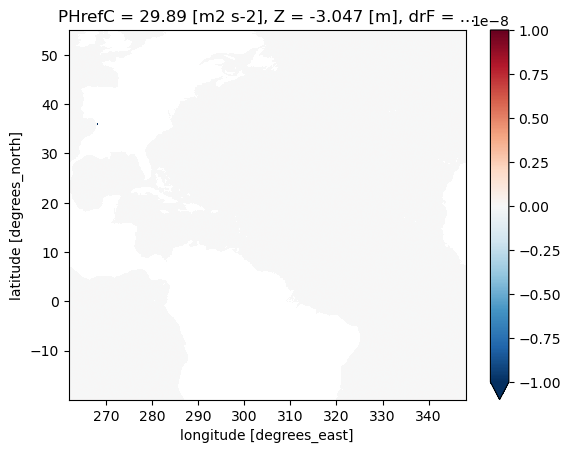

In [18]:
(dst.TEND / 86400 - rhs0).sel(Z=-1000,method='nearest').plot(vmax=1e-8)

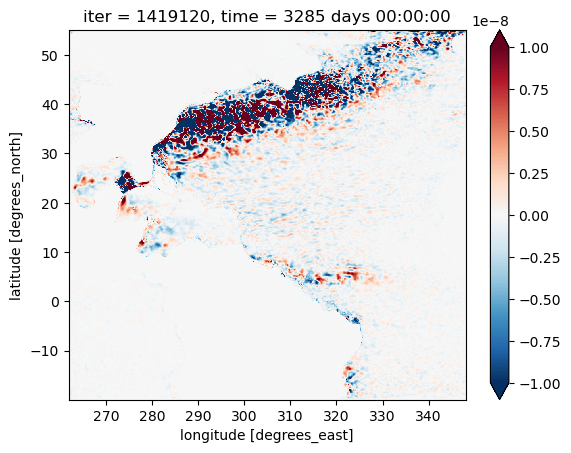

In [20]:
(((dst.TEND / 86400 - rhs1) * dsg.drF
 ).sel(Z=slice(None,-1000)).sum('Z',skipna=True)
 / 1e3).plot(vmax=1e-8)

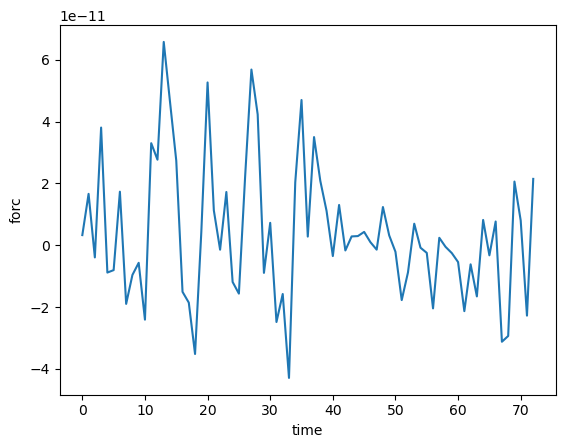

In [7]:
ymax = 43
ymin = 14
xmin = 270
xmax = 337
dse = xr.open_zarr(op.join(savedir,
                           '%4d/EKE_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsp = xr.open_zarr(op.join(savedir,
                           '%4d/Eddy/PRES_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsab = xr.open_zarr(op.join(savedir,
                           '%4d/Eddy/A-B_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dswb = xr.open_zarr(op.join(savedir,
                            '%4d/wpbp_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                            # '%4d/wpbp_VolAveZ1000_%2dN.zarr' 
                            # % (years[yystart],ymin)
                           ))
# dsh = xr.open_zarr(op.join(savedir,
#                            '%4d/Divh_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
#                            % (years[0],ymin,ymax,xmin,xmax)))
dsH_ = xr.open_zarr(op.join(savedir,
                            '%4d/GradH_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                            % (years[0],ymin,ymax,xmin,xmax)
                            # '%4d/GradH_VolAveZ1000_%2dN.zarr' 
                            # % (years[yystart],ymin)
                           ))
dsk = xr.open_zarr(op.join(savedir,
                           '%4d/K-k_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dss = xr.open_zarr(op.join(savedir,'%4d/S-P_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dst = xr.open_zarr(op.join(savedir,
                           '%4d/EKETEND_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsd = xr.open_zarr(op.join(savedir,
                           '%4d/EKEDISS_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsa = xr.open_zarr(op.join(savedir,
                           '%4d/EKEADV_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsf = xr.open_zarr(op.join(savedir,
                           # '%4d/EKEFORC_VolAve_%2dN-%2dN%3dE-%3dE.zarr' 
                           '%4d/EKEFORC_VolAveZ1000_%2dN-%2dN%3dE-%3dE.zarr' 
                           % (years[0],ymin,ymax,xmin,xmax)))
dsf.forc.plot()

In [8]:
from datetime import timedelta
time = np.arange('1967-01-01', '1968-01-01', timedelta(days=5), dtype='datetime64[D]')
time

array(['1967-01-01', '1967-01-06', '1967-01-11', '1967-01-16',
       '1967-01-21', '1967-01-26', '1967-01-31', '1967-02-05',
       '1967-02-10', '1967-02-15', '1967-02-20', '1967-02-25',
       '1967-03-02', '1967-03-07', '1967-03-12', '1967-03-17',
       '1967-03-22', '1967-03-27', '1967-04-01', '1967-04-06',
       '1967-04-11', '1967-04-16', '1967-04-21', '1967-04-26',
       '1967-05-01', '1967-05-06', '1967-05-11', '1967-05-16',
       '1967-05-21', '1967-05-26', '1967-05-31', '1967-06-05',
       '1967-06-10', '1967-06-15', '1967-06-20', '1967-06-25',
       '1967-06-30', '1967-07-05', '1967-07-10', '1967-07-15',
       '1967-07-20', '1967-07-25', '1967-07-30', '1967-08-04',
       '1967-08-09', '1967-08-14', '1967-08-19', '1967-08-24',
       '1967-08-29', '1967-09-03', '1967-09-08', '1967-09-13',
       '1967-09-18', '1967-09-23', '1967-09-28', '1967-10-03',
       '1967-10-08', '1967-10-13', '1967-10-18', '1967-10-23',
       '1967-10-28', '1967-11-02', '1967-11-07', '1967-

In [9]:
rhs0 = ((dsp.PRES 
         # - dsb.wb    # (= - dsh.Gh - dsH.H_)
         # + dsh.Gh
        ) 
        + dsa.advec
        # + dsH.H_
        + dsd.diss
        + dsab.ADAM
        + dsf.forc
       )
# rhs1 = ((dse.PRES 
#          - dsb.wb    # (= - dsh.Gh - dsH.H_)
#          + dsh.Gh
#         ) 
#         + (grid.interp(dsa.Um_Advec,"X") 
#            + grid.interp(dsa.Vm_Advec,"Y",boundary='extend'))
#         + dsH.H_
#         + (grid.interp(dsd.Um_diss+dsv.Um_disv,'X') 
#            + grid.interp(dsd.Vm_diss+dsv.Vm_disv,'Y',boundary='extend')
#           ) + dse.ADAM
#        )

rhs0

<xarray.DataArray (time: 73)>
dask.array<add, shape=(73,), dtype=float64, chunksize=(73,), chunktype=numpy.ndarray>
Dimensions without coordinates: time

Text(0, 0.5, 'Terms in EKE budget')

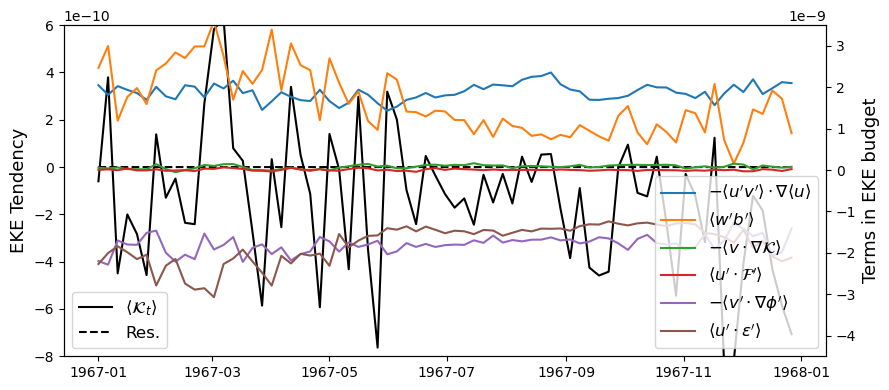

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, dst.TEND/86400, 'k', label=r"$\langle\mathcal{K}_t\rangle$")
ax.plot(time, (dst.TEND/86400-rhs0), 'k--', label=r"Res.")

ax2.plot(time, -dss.ShProd, label=r"$-\langle u'v'\rangle\cdot\nabla\langle u\rangle$")
ax2.plot(time, dswb.wb, label=r"$\langle w'b'\rangle$")
ax2.plot(time, (dsa.advec+dss.ShProd), label=r"$-\langle v\cdot\nabla\mathcal{K}\rangle$")
ax2.plot(time, dsf.forc, label=r"$\langle u'\cdot \mathcal{F}'\rangle$")
ax2.plot(time, dsp.PRES-dswb.wb, label=r"$-\langle v'\cdot\nabla\phi'\rangle$")
ax2.plot(time, dsd.diss, label=r"$\langle u'\cdot\epsilon'\rangle$")

ax.set_ylim([-8e-10,6e-10])
ax2.set_ylim([-4.5e-9,3.5e-9])

ax.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax.set_ylabel(r"EKE Tendency", fontsize=13)
ax2.set_ylabel(r"Terms in EKE budget", fontsize=13)